# TrRosetta 

## Method

TrRosetta is a deep residual convolutional network takes in input a MSA and outputs the relative distance and orientation of each residue pair.
The output includes the probability for the distance range 2 to 20 A, binned in 36 bins of 0.5 A each (plus 1 bin for no contact), and other bins for angles.

## Installation

Easiest way is to use singularity with the tf1 CPU container (needs a lot of RAM)

```
singularity pull docker://tensorflow/tensorflow:1.15.5
```

Clone the repository and download the trained model.

```
git clone https://github.com/gjoni/trRosetta
cd trRosetta
wget https://files.ipd.uw.edu/pub/trRosetta/model2019_07.tar.bz2
tar xf model2019_07.tar.bz2
```


## How to run

Go to the root of the repository and run:

```
singularity run singularity_containers/tensorflow_1.15.5.sif
python ./network/predict.py -m ./model2019_07 <a3m MSA input> <npz file output>
```

## Notes

In general the trimmed MSA seem to be better than the full lenght ones.

## Creation of a dataframe with distances for trRosetta predictions and PDB structures

In [2]:
import pandas as pd

# extract distances from trRosetta distograms
df = pd.read_csv('../../dataset/dms_training.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/dms_training.csv'

In [ ]:
distogram_bins_map = {i:(dist/10) for i,dist in enumerate([np.nan] + list(range(20,205,5)))}
map_to_dist = np.vectorize(lambda x : distogram_bins_map[x])
tr_rosetta_distance_df_all_proteins = pd.DataFrame()
for trrosetta_basename in set(df.feature_basename_trrosetta):
    trrosetta_uniprot_firsts = set(df[df.feature_basename_trrosetta == trrosetta_basename].mutated_domain_uniprot_first)
    assert len(trrosetta_uniprot_firsts) == 1
    trrosetta_uniprot_first = trrosetta_uniprot_firsts.pop()
    distogram = np.load('/home/saul/master_thesis_work/processing/tr_rosetta/' + trrosetta_basename + '_trRosetta.npz')['dist']
    best_bins = np.argmax(distogram, axis=2)
    tr_rosetta_distances = map_to_dist(best_bins)
    G = nx.Graph()
    for i, row in enumerate(tr_rosetta_distances):
        G.add_node(i)
        for j, el in enumerate(row):
            if i >= j and el < contact_treshold:
                G.add_edge(i, j)
    assert G.number_of_nodes() == tr_rosetta_distances.shape[0]
    graph_df = pd.DataFrame()
    graph_df['tr_rosetta_feature_index'] = range(tr_rosetta_distances.shape[0])
    graph_df['tr_rosetta_graph_closeness_centrality'] = graph_df['tr_rosetta_feature_index'].map(nx.closeness_centrality(G))
    graph_df['tr_rosetta_graph_betweenness_centrality'] = graph_df['tr_rosetta_feature_index'].map(nx.betweenness_centrality(G, normalized=True))
    graph_df['tr_rosetta_graph_degree_centrality'] = graph_df['tr_rosetta_feature_index'].map(nx.degree_centrality(G))
    graph_df['tr_rosetta_graph_load_centrality'] = graph_df['tr_rosetta_feature_index'].map(nx.load_centrality(G, normalized=True))
    graph_df['tr_rosetta_graph_harmonic_centrality'] = graph_df['tr_rosetta_feature_index'].map(nx.harmonic_centrality(G))/100
    graph_df['tr_rosetta_graph_clustering'] = graph_df['tr_rosetta_feature_index'].map(nx.clustering(G))
    graph_df['feature_basename_trrosetta'] = trrosetta_basename
    # this is a position and not an index since trtrrosetta_uniprot_first is 1-indexed
    # It is position and not feature_position since it refers to the full uniprot seq
    graph_df['position'] = trrosetta_uniprot_first + graph_df['tr_rosetta_feature_index']
    tr_rosetta_graph_df_all_proteins = pd.concat([tr_rosetta_graph_df_all_proteins, graph_df])

## Output check

I compare the trRosetta distogram with the one derived from the actual structure. Since for some proteins the crystal refers to a different repeat of the same domain, I use the unmapped PDB contact map.

trRosetta trimmed distogram beta-lactamase


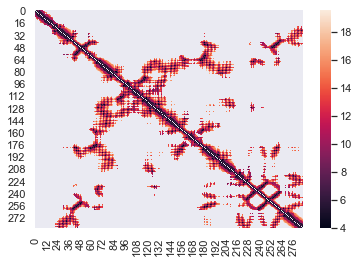

trRosetta full distogram beta-lactamase


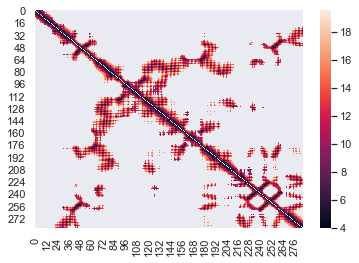

PDB distogram beta-lactamase


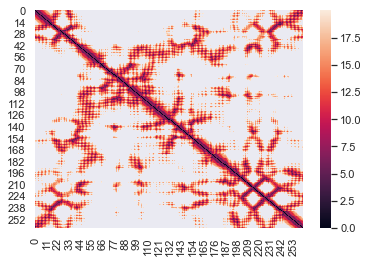

Uniprot mapped distogram beta-lactamase


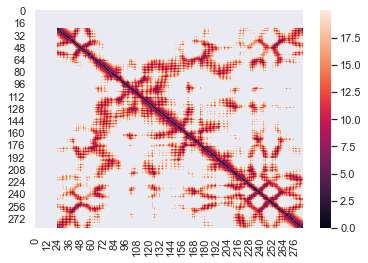

trRosetta trimmed distogram WW_domain


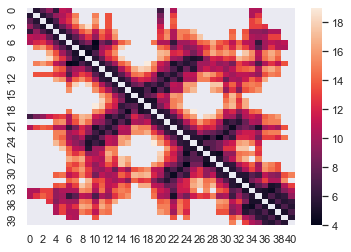

Full trRosetta output missing for WW_domain
PDB distogram WW_domain


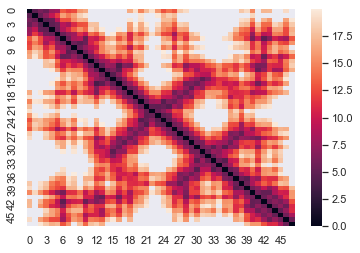

Uniprot mapped distogram WW_domain


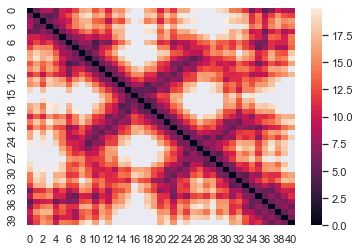

trRosetta trimmed distogram PSD95pdz3


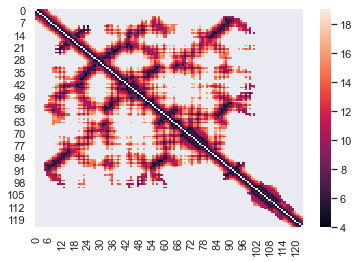

Full trRosetta output missing for PSD95pdz3
PDB distogram PSD95pdz3


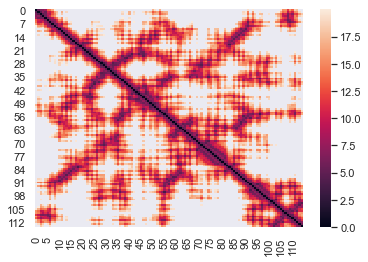

Uniprot mapped distogram PSD95pdz3


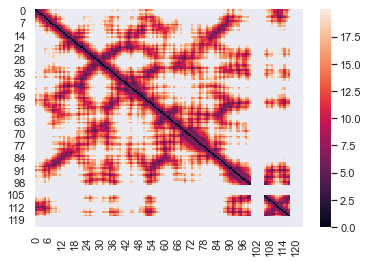

trRosetta trimmed distogram kka2_1:2


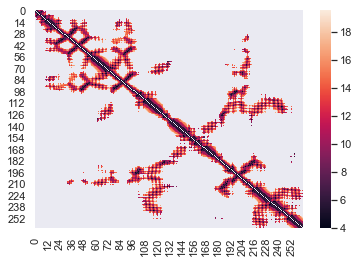

trRosetta full distogram kka2_1:2


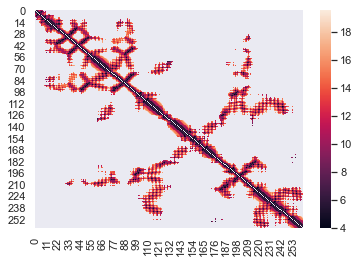

PDB distogram kka2_1:2


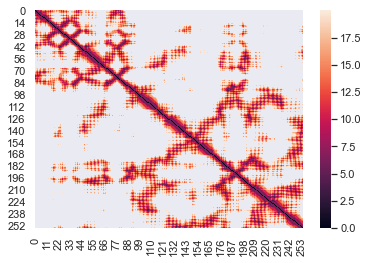

Uniprot mapped distogram kka2_1:2


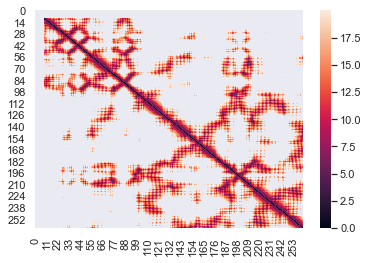

trRosetta trimmed distogram hsp90


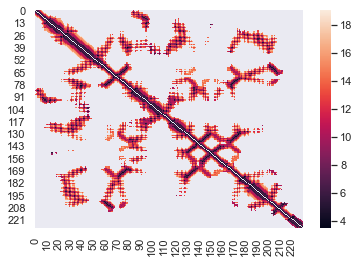

Full trRosetta output missing for hsp90
PDB distogram hsp90


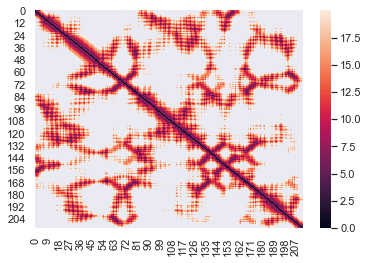

Uniprot mapped distogram hsp90


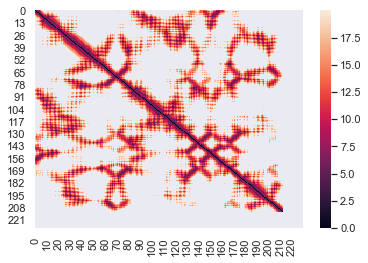

trRosetta trimmed distogram Ubiquitin


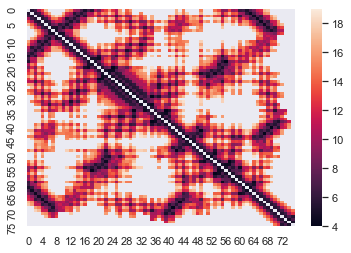

Full trRosetta output missing for Ubiquitin
PDB distogram Ubiquitin


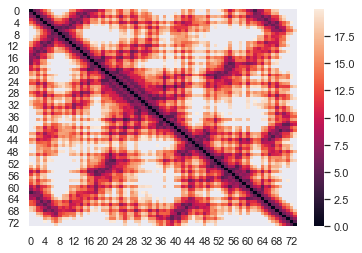

Uniprot mapped distogram Ubiquitin


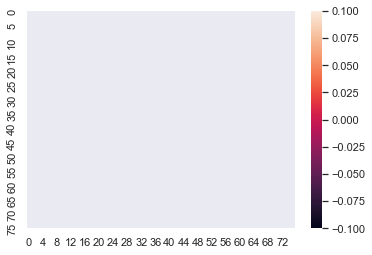

trRosetta trimmed distogram Pab1


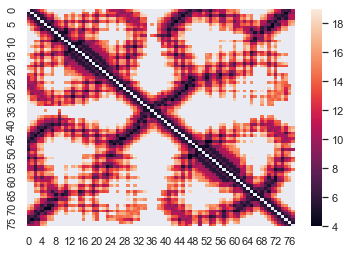

Full trRosetta output missing for Pab1
PDB distogram Pab1


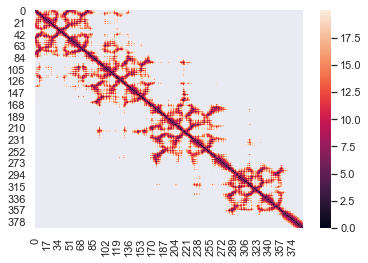

Uniprot mapped distogram Pab1


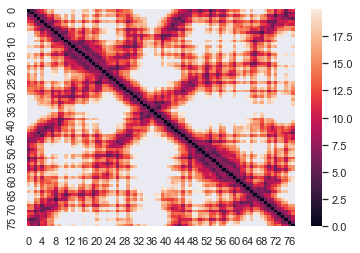

trRosetta trimmed distogram E1_Ubiquitin


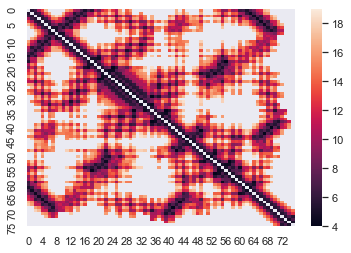

Full trRosetta output missing for E1_Ubiquitin
PDB distogram E1_Ubiquitin


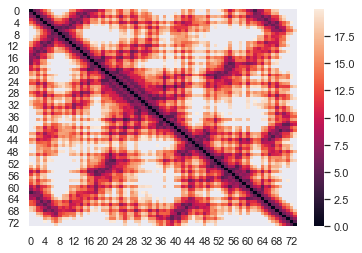

Uniprot mapped distogram E1_Ubiquitin


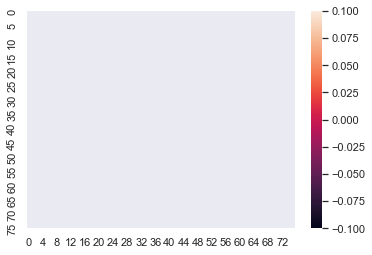

trRosetta trimmed distogram gb1


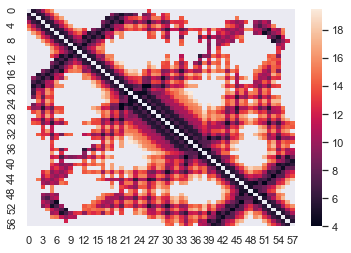

Full trRosetta output missing for gb1
PDB distogram gb1


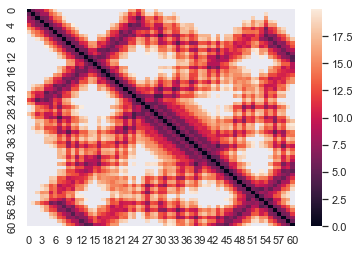

Uniprot mapped distogram gb1


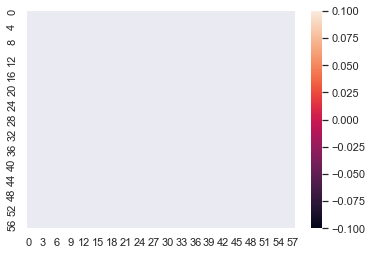

In [3]:
import numpy as np
import joblib
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

dms_datasets_df = pd.read_csv('/home/saul/master_thesis_work/dataset/dms/dms_datasets.csv')

# vectorized functions
crop_distances = np.vectorize(lambda x : (x if x<=20 else np.nan))
distogram_bins_map = {i:(dist/10) for i,dist in enumerate([np.nan] + list(range(20,205,5)))}
map_to_dist = np.vectorize(lambda x : distogram_bins_map[x])
    
for study in dms_datasets_df.dms_id:
    assert len(dms_datasets_df[dms_datasets_df.dms_id == study]) == 1
    basename_trimmed = set(dms_datasets_df[dms_datasets_df.dms_id == study].feature_basename_trrosetta).pop()
    pdb_id = set(dms_datasets_df[dms_datasets_df.dms_id == study].pdb_id).pop()
    pdb_chain = set(dms_datasets_df[dms_datasets_df.dms_id == study].pdb_chain).pop()
    uniprot_id = set(dms_datasets_df[dms_datasets_df.dms_id == study].uniprot_id).pop()
    uniprot_first = set(dms_datasets_df[dms_datasets_df.dms_id == study].mutated_domain_uniprot_first).pop()
    uniprot_last = set(dms_datasets_df[dms_datasets_df.dms_id == study].mutated_domain_uniprot_last).pop()
    # trRosetta distances
    try: # not all sequences have a trimmed version
        distogram = np.load('/home/saul/master_thesis_work/processing/dms/tr_rosetta/' + basename_trimmed + '_trRosetta.npz')['dist']
        best_bins = np.argmax(distogram, axis=2)
        tr_rosetta_distances = map_to_dist(best_bins)
        print('trRosetta trimmed distogram', study)
        plt.close()
        sns.heatmap(tr_rosetta_distances)
        plt.show()
    except:
        print("Trimmed trRosetta output missing for", study)
    # trRosetta distances for the untrimmed protein
    try: # the trrosetta map does not exists for all the proteins
        distogram = np.load('/home/saul/master_thesis_work/processing/dms/tr_rosetta/' + uniprot_id + '_trRosetta.npz')['dist']
        best_bins = np.argmax(distogram, axis=2)
        tr_rosetta_distances = map_to_dist(best_bins)
        print('trRosetta full distogram', study)
        plt.close()
        sns.heatmap(tr_rosetta_distances[uniprot_first - 1:uniprot_last, uniprot_first - 1:uniprot_last])
        plt.show()
    except:
        print("Full trRosetta output missing for", study)
    # calculating PDB distances
    pdb_distances = joblib.load('/home/saul/master_thesis_work/processing/dms/structures/' +
                            pdb_id + '_' + pdb_chain + '.pdb_distance_matrix.joblib.xz')['distance_matrix']
    print('PDB distogram', study)
    plt.close()
    sns.heatmap(crop_distances(pdb_distances))
    plt.show()
    # experimental cmap mapped to uniprot
    uniprot_distances = joblib.load('/home/saul/master_thesis_work/processing/dms/structures/' +
                                    uniprot_id + '_mapped_' + pdb_id + '_' + pdb_chain +
                                    '.uniprot_distance_matrix.joblib.xz')['distance_matrix']
    print('Uniprot mapped distogram', study)
    plt.close()
    sns.heatmap(crop_distances(uniprot_distances[uniprot_first - 1:uniprot_last, uniprot_first - 1:uniprot_last]))
    plt.show()